In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from scipy.stats import spearmanr


In [ ]:
# ===============================================================
# COACH CHANGE PREDICTION — DATA PREPARATION
# ===============================================================

# Load Data
coaches = pd.read_csv("data/coaches.csv")
teams = pd.read_csv("data/teams.csv")
awards_players = pd.read_csv("data/awards_players.csv")

# Add info about next year's coach (target variable)
coaches["next_coachID"] = coaches.groupby("tmID")["coachID"].shift(-1)
coaches["coach_changed_next_year"] = (coaches["coachID"] != coaches["next_coachID"]).astype(int)


# Compute win ratio
coaches["win_ratio"] = coaches["won"] / (coaches["won"] + coaches["lost"])
coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)


# Shift the data so each year uses the previous year's 
coaches["prev_win_ratio"] = coaches.groupby("tmID")["win_ratio"].shift(1)

# merge teams info into coaches so each coach row has that season's team info
coaches = coaches.merge(
    teams[["year", "tmID", "rank", "playoff"]],
    on=["year", "tmID"],
    how="left",
    validate="m:1"   # optional, sanity check: many coaches rows -> one team row
)

coaches = coaches.sort_values(["tmID", "year"]).reset_index(drop=True)

coaches["prev_rank"] = coaches.groupby("tmID")["rank"].shift(1)
coaches["prev_playoff"] = coaches.groupby("tmID")["playoff"].shift(1).map({"Y": 1, "N": 0})

coaches["prev_playoff"] = coaches["prev_playoff"].map({"Y": 1, "N": 0})


# Fill NaNs in prev_win_ratio with average win ratio all time
#average_win_ratio = coaches["win_ratio"].mean()
#coaches["prev_win_ratio"] = coaches["prev_win_ratio"].fillna(average_win_ratio)

# Playoff miss streak
def playoff_streak(series):
    streaks = []
    streak = 0
    for made in series:
        if made == 0:
            streak += 1
        else:
            streak = 0
        streaks.append(streak)
    return streaks

coaches["playoff_miss_streak"] = coaches.groupby("tmID")["prev_playoff"].transform(playoff_streak)


# 3-year rolling average of win ratio (performance trend)
coaches["3yr_win_ratio"] = (
    coaches.groupby("tmID")["prev_win_ratio"]
    .rolling(window=3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)
# Expectation gap (current vs. recent average)
coaches["expectation_gap"] = coaches["prev_win_ratio"] - coaches["3yr_win_ratio"]



# Team stability index (how often the team fires coaches)
coaches["team_stability_index"] = (
    coaches.groupby("tmID")["coach_changed_next_year"]
    .shift(1)  # only use previous seasons
    .rolling(3, min_periods=1)
    .mean()
    .reset_index(level=0, drop=True)
)


# Years with team (coach tenure)
coaches = coaches.sort_values(["coachID", "tmID", "stint", "year"])
coaches["years_with_team_stint"] = (
    coaches.groupby(["coachID", "tmID", "stint"]).cumcount() + 1
)

coaches_year = coaches[coaches["year"] == 9]
#coaches_year.head(20)

Treino: (146, 20) | Teste (10): (16, 20)

Evaluation for year 10:
Accuracy:  0.688
Precision: 1.000
Recall:    0.688
F1-score:  0.815
Spearman: nan (p=nan)

🏀 Top predicted coach changes (with actual result):
     year     coachID  pred_proba  predicted_change  coach_changed_next_year
95     10  donovan99w    0.718523                 1                        1
161    10  plankju99w    0.614194                 1                        1
36     10  mahorri01w    0.609333                 1                        1
13     10   keyst99wc    0.532410                 1                        1
124    10  bouceje01w    0.516554                 1                        1
35     10  laimbbi01w    0.510838                 1                        1
125    10  whisejo99w    0.498491                 1                        1
55     10  dunnli99wc    0.497123                 1                        1
24     10  thibami99w    0.456752                 1                        1
83     10  gilloje01w

/tmp/ipykernel_15564/2694886954.py:53: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])


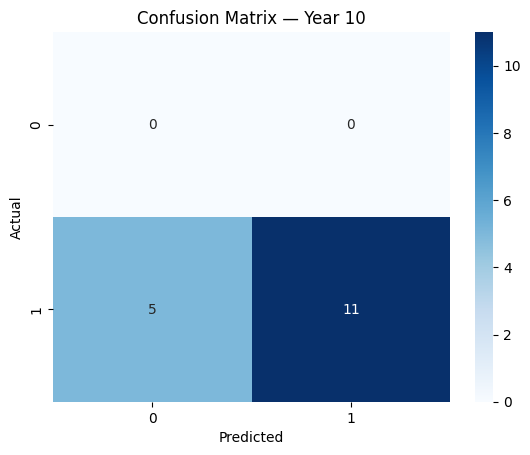

/tmp/ipykernel_15564/2694886954.py:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")


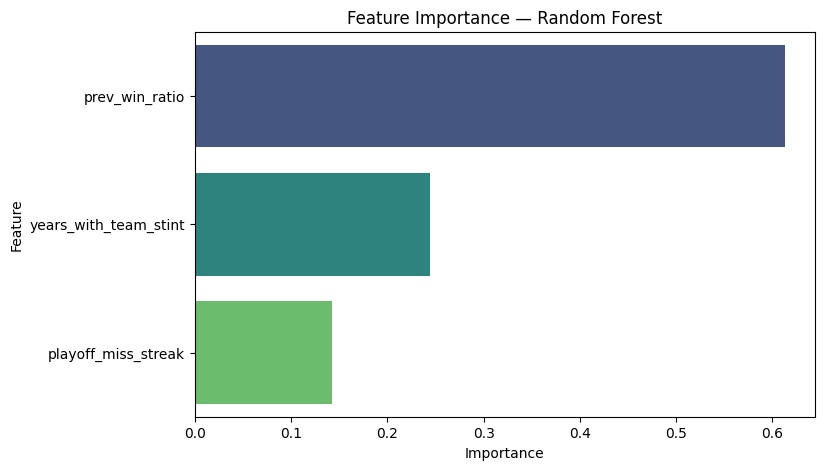


Feature Influence (higher = more impact on firing prediction):
                 Feature  Importance
0         prev_win_ratio    0.613589
2  years_with_team_stint    0.244027
1    playoff_miss_streak    0.142384


In [ ]:
# ===============================================================
# COACH CHANGE PREDICTION — MODEL & EVALUATION
# ===============================================================

target_year = 10
train_data = coaches[coaches["year"] < target_year]
test_data  = coaches[coaches["year"] == target_year]

print(f"Treino: {train_data.shape} | Teste ({target_year}): {test_data.shape}")

# Define features and target

features = [
    "prev_win_ratio"
    #,"3yr_win_ratio"
    #"expectation_gap"
    #,"prev_rank"
    #,"prev_playoff"
    ,"playoff_miss_streak"
    ,"years_with_team_stint"
    #,"team_stability_index"
    
]
target = "coach_changed_next_year"

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)


# Predictions

test_data = test_data.copy()
test_data.loc[:, "pred_proba"] = model.predict_proba(X_test)[:, 1]

threshold = 0.4
test_data.loc[:, "predicted_change"] = (test_data["pred_proba"] > threshold).astype(int)


acc = accuracy_score(y_test, test_data["predicted_change"])
prec = precision_score(y_test, test_data["predicted_change"])
rec = recall_score(y_test, test_data["predicted_change"])
f1 = f1_score(y_test, test_data["predicted_change"])
spearman_corr, spearman_p = spearmanr(y_test, test_data["pred_proba"])

print(f"\nEvaluation for year {target_year}:")
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall:    {rec:.3f}")
print(f"F1-score:  {f1:.3f}")
print(f"Spearman: {spearman_corr:.3f} (p={spearman_p:.3f})")

print("\n🏀 Top predicted coach changes (with actual result):")
print(
    test_data[[
        "year", "coachID", "pred_proba",
        "predicted_change", "coach_changed_next_year"
    ]]
    .sort_values("pred_proba", ascending=False)
    .head(20)
)

# Evaluation


# Confusion Matrix

# Column [0]: probability of class 0: coach stays

# Column [1]: probability of class 1: coach changes/fired


cm = confusion_matrix(y_test, test_data["predicted_change"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — Year {target_year}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance

importance = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
plt.title("Feature Importance — Random Forest")
plt.show()

print("\nFeature Influence (higher = more impact on firing prediction):")
print(importance)
